## Portfolio Risk and Stress Testing Analysis

This notebook evaluates the risk and performance of a hypothetical $100,000 investment portfolio from April 2020 to April 2025. The portfolio includes a mix of equities, bonds, commodities, and real estate. The analysis covers:

- Historical return and volatility
- Sharpe and Sortino ratios
- Value at Risk (VaR) and Conditional VaR (CVaR)
- Asset correlation
- Risk contributions
- Stress test scenarios and reverse stress testing


## Key Takeaways

Stress Testing Results:

- Worst-case scenarios include Liquidity Crisis (-22.50%) and Global Equity Crash (-19.25%).

- Defensive assets like gold and bonds offer partial protection during crises.

Reverse Stress Testing:

- Catastrophic portfolio loss (-50%) would require extreme shocks across all assets, e.g., SPY (-142%), AAPL/MSFT (-333%).

## Import Librairies

In [25]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Create an Hypothetical Portfolio and set up parameters

In [26]:
portfolio_weights = {
    "SPY": 0.35,   # S&P 500 ETF
    "AAPL": 0.15,  # Apple Inc.
    "MSFT": 0.15,  # Microsoft Corp.
    "LQD": 0.10,   # Corporate Bond ETF
    "GLD": 0.10,   # Gold ETF
    "USO": 0.10,   # Crude Oil ETF
    "VNQ": 0.10    # Real Estate ETF
}

start_date = '2020-04-01'
end_date = '2025-04-04'

### Portfolio Overview
The portfolio consists of seven asset classes:

Equities: S&P 500 ETF (SPY), Apple Inc. (AAPL), Microsoft Corp. (MSFT)

Bonds: Corporate Bond ETF (LQD)

Commodities: Gold ETF (GLD), Crude Oil ETF (USO)

Real Estate: Real Estate ETF (VNQ)

Weights are assigned to each asset, with equities dominating the portfolio at 65% combined weight.

## Data Download from Yahoo Finance

We retrieve daily historical closing prices for all portfolio assets using the `yfinance` library, covering the period from April 2020 to April 2025.

In [27]:
data = yf.download(list(portfolio_weights.keys()), start=start_date, end=end_date)
close_prices = data['Close']
close_prices.to_csv("portfolio_historical_data.csv")

[*********************100%***********************]  7 of 7 completed


## Portfolio Returns Calculation

We compute daily returns of each asset and apply the portfolio weights to calculate the overall portfolio's daily returns. We also calculate cumulative returns over the investment period.

In [28]:
daily_returns = close_prices.pct_change().dropna()

weights_df = pd.DataFrame([portfolio_weights]).reindex(columns=daily_returns.columns)

weighed_returns = daily_returns * weights_df.iloc[0]

portfolio_returns = weighed_returns.sum(axis=1)
portfolio_returns.to_csv("portfolio_returns.csv")

cumulative_returns = (1+daily_returns).cumprod() - 1
portfolio_cumulative_returns = (1+portfolio_returns).cumprod() - 1

## Portfolio vs Benchmark (S&P 500)

We compare the portfolio's cumulative returns against the S&P 500 ETF (SPY) to evaluate relative performance.

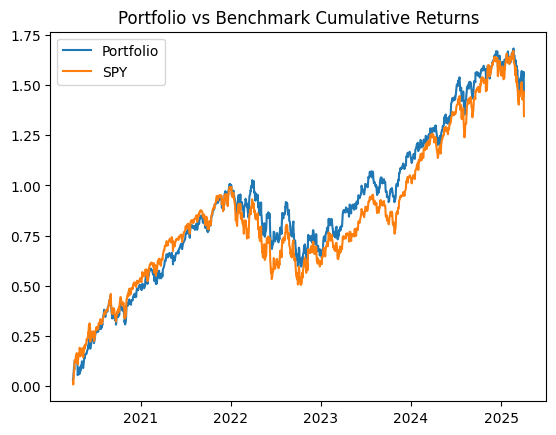

In [29]:
benchmark = close_prices["SPY"].pct_change().dropna()
benchmark_cum = (1 + benchmark).cumprod() - 1
plt.plot(portfolio_cumulative_returns, label='Portfolio')
plt.plot(benchmark_cum, label='SPY')
plt.title('Portfolio vs Benchmark Cumulative Returns')
plt.legend()
plt.show()

## Asset Correlation Matrix

We analyze the correlation between assets to understand diversification benefits and dependencies within the portfolio.

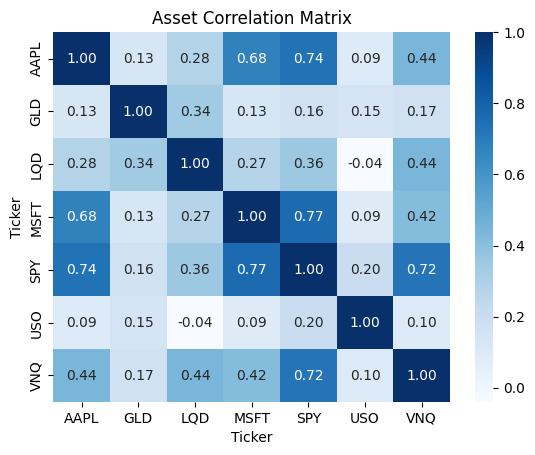

In [30]:
correlation_matrix = daily_returns.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title("Asset Correlation Matrix")
plt.show()

## Sharpe and Sortino Ratios

- **Sharpe Ratio**: Measures risk-adjusted return relative to total volatility.
- **Sortino Ratio**: Focuses on downside risk only, offering a more conservative risk-adjusted metric.

In [31]:
# Sharpe Ratio
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")


# Sortino Ratio
downside_returns = portfolio_returns[portfolio_returns < 0]
sortino_ratio = portfolio_returns.mean() / downside_returns.std()
print(f"Portfolio Sortino Ratio: {sortino_ratio:.4f}")

Portfolio Sharpe Ratio: 0.0742
Portfolio Sortino Ratio: 0.1007


Sharpe Ratio: indicating modest risk-adjusted returns relative to total volatility.

Sortino Ratio: reflecting slightly better risk-adjusted returns when focusing on downside volatility.

## Value at Risk (VaR) and Expected Shortfall (CVaR)

- **VaR (95%)**: Maximum expected portfolio loss with 95% confidence on a single day.
- **CVaR (or Expected Shortfall)**: Average loss on days when the loss exceeds the VaR threshold.

In [32]:
# VaR 95
confidence_level = 0.95

var_95 = portfolio_returns.quantile(1-confidence_level)
print(f"Value at Risk (VaR) at {confidence_level*100:.0f}% confidence level: {var_95:.4f}")


# Expected Shortfall (or CVaR)
threshold = portfolio_returns.quantile(1-confidence_level)
es_95 = portfolio_returns[portfolio_returns <= threshold].mean()
print(f"Expected Shortfall (ES) at {confidence_level*100:.0f}% confidence level: {es_95*100:.2f}%")

Value at Risk (VaR) at 95% confidence level: -0.0160
Expected Shortfall (ES) at 95% confidence level: -2.41%


## Risk Contributions by Asset

We compute the **marginal VaR** of each asset and multiply it by the portfolio weights to assess which assets contribute most to portfolio risk.


In [33]:
marginal_var = daily_returns.apply(lambda x: x.cov(portfolio_returns)) / portfolio_returns.var()
print("\nMarginal VaR:")
print(marginal_var)

risk_contributions = marginal_var * pd.Series(portfolio_weights)
print("\nRisk Contribution by Asset:")
print(risk_contributions)


Marginal VaR:
Ticker
AAPL    1.445815
GLD     0.268216
LQD     0.226074
MSFT    1.344340
SPY     1.000792
USO     0.929177
VNQ     0.888527
dtype: float64

Risk Contribution by Asset:
AAPL    0.216872
GLD     0.026822
LQD     0.022607
MSFT    0.201651
SPY     0.350277
USO     0.092918
VNQ     0.088853
dtype: float64


SPY contributes the most risk due to its high weight (35%).

AAPL and MSFT also contribute significantly due to their weights and volatility.

GLD and LQD contribute less, highlighting their lower-risk profiles.

## Portfolio Return Distribution with VaR and CVaR

A histogram of portfolio returns is plotted along with lines marking the VaR and CVaR, illustrating the distribution's left tail.


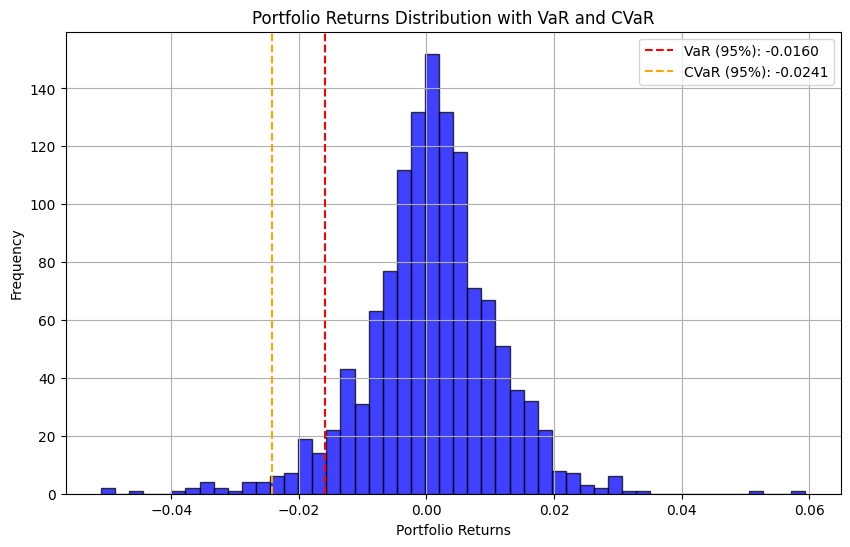

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(var_95, color='red', linestyle='--', label=f'VaR (95%): {var_95:.4f}')
plt.axvline(es_95, color='orange', linestyle='--', label=f'CVaR (95%): {es_95:.4f}')
plt.title('Portfolio Returns Distribution with VaR and CVaR')
plt.xlabel('Portfolio Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

## Stress Testing Scenarios

We evaluate how the portfolio might perform under 6 extreme but plausible market scenarios, including:

- Global equity crash
- Inflation surge
- Interest rate shock
- Geopolitical crisis
- Liquidity crisis
- Tech sector meltdown

Each scenario applies shocks to individual assets, and we calculate the resulting impact on the portfolio.

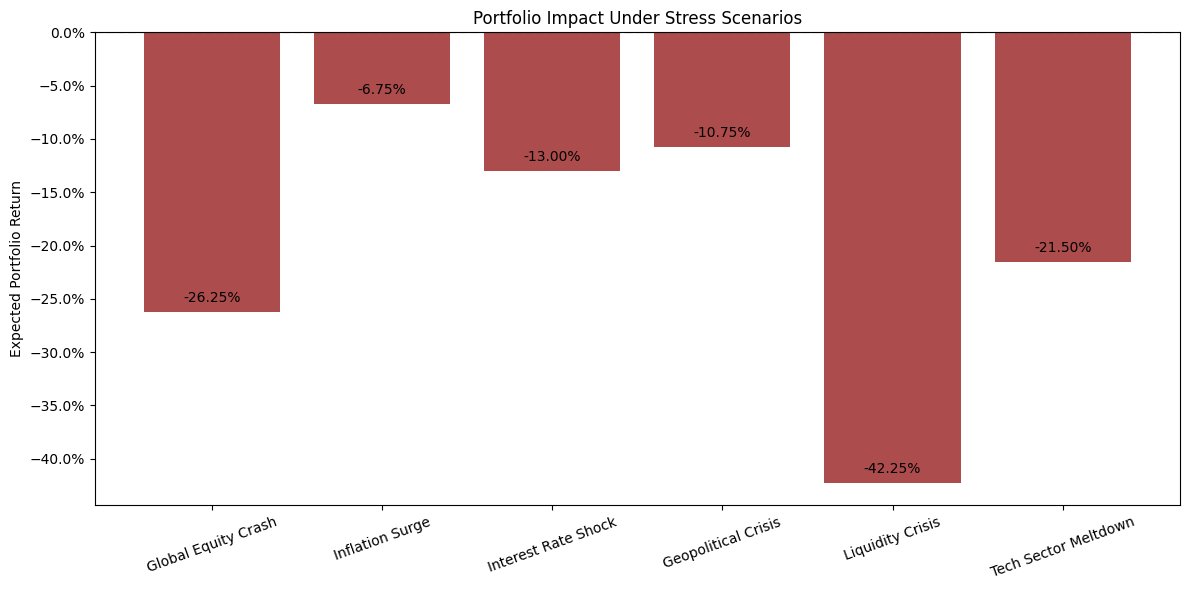

In [35]:
# Scenario 1: Global Equity Crash
stress_scenario_1 = {
    "SPY": -0.35,   # Broad equity market crash (35% drop)
    "AAPL": -0.40,  # Tech stocks hit harder (40% drop)
    "MSFT": -0.40,
    "LQD": 0.10,    # Flight to quality (corporate bonds rise 10%)
    "TLT": 0.15,    # Long-term Treasuries surge (15% gain)
    "GLD": 0.25,    # Gold spikes as safe haven (25% gain)
    "USO": -0.30,   # Oil demand collapses (30% drop)
    "VNQ": -0.25    # Real estate crash (25% drop)
}

# Scenario 2: Inflation Surge
stress_scenario_2 = {
    "SPY": -0.15,   # Equities struggle with high rates
    "AAPL": -0.20,
    "MSFT": -0.20,
    "LQD": -0.25,   # Corporate bonds hurt by rising defaults
    "TLT": -0.30,   # Long-term bonds crash (rates ↑)
    "GLD": 0.40,    # Gold rallies (inflation hedge)
    "USO": 0.50,    # Oil spikes (supply constraints)
    "VNQ": -0.20    # Real estate suffers (mortgage costs ↑)
}

# Scenario 3: Interest Rate Shock
stress_scenario_3 = {
    "SPY": -0.10,   # Equities decline moderately
    "AAPL": -0.15,
    "MSFT": -0.15,
    "LQD": -0.20,   # Corporate bonds lose value (spreads widen)
    "TLT": -0.35,   # Long-term Treasuries collapse (yields spike)
    "GLD": 0.10,    # Modest gold gains
    "USO": -0.10,   # Oil demand weakens
    "VNQ": -0.30    # Real estate plummets (financing costs ↑)
}

# Scenario 4: Geopolitical Crisis
stress_scenario_4 = {
    "SPY": -0.25,   # Global equity sell-off
    "AAPL": -0.30,
    "MSFT": -0.30,
    "LQD": -0.15,   # Corporate bonds pressured
    "TLT": 0.20,    # Treasuries rally (safe haven)
    "GLD": 0.35,    # Gold surges
    "USO": 0.60,    # Oil spikes (supply disruptions)
    "VNQ": -0.10    # Real estate mixed
}

# Scenario 5: Liquidity Crisis
stress_scenario_5 = {
    "SPY": -0.45,   # Equities crash (forced selling)
    "AAPL": -0.50,
    "MSFT": -0.50,
    "LQD": -0.40,   # Corporate bonds illiquid
    "TLT": 0.05,    # Treasuries modestly gain
    "GLD": 0.15,    # Gold gains limited
    "USO": -0.50,   # Oil collapses (demand destruction)
    "VNQ": -0.40    # Real estate frozen
}

# Scenario 6: Tech Sector Meltdown
stress_scenario_6 = {
    "SPY": -0.10,   # Broad market slightly down
    "AAPL": -0.60,  # Tech-specific crash
    "MSFT": -0.60,
    "LQD": 0.05,    # Bonds stable
    "TLT": 0.10,    # Treasuries gain modestly
    "GLD": 0.0,     # No change
    "USO": 0.0,     # No change
    "VNQ": -0.05    # Minor real estate impact
}

# Create function for stress test
def apply_stress_scenario(scenario_dict, weights):
    # Calculate total portfolio impact based on asset shocks and weights
    return sum(scenario_dict[asset] * weights.get(asset, 0) for asset in scenario_dict)



stress_scenarios = {
    "Global Equity Crash": stress_scenario_1,
    "Inflation Surge": stress_scenario_2,
    "Interest Rate Shock": stress_scenario_3,
    "Geopolitical Crisis": stress_scenario_4,
    "Liquidity Crisis": stress_scenario_5,
    "Tech Sector Meltdown": stress_scenario_6
}

scenario_names = list(stress_scenarios.keys())
scenario_impacts = [apply_stress_scenario(scenario, portfolio_weights) for scenario in stress_scenarios.values()]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(scenario_names, scenario_impacts, color='darkred', alpha=0.7)

ax.set_title("Portfolio Impact Under Stress Scenarios")
ax.set_ylabel("Expected Portfolio Return")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=20)
plt.axhline(0, color='black', linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

The analysis reveals that scenarios involving broad equity crashes or liquidity crises have the most severe impacts on portfolio performance.

## Reverse Stress Testing

This analysis determines the asset return shocks required to cause a specified portfolio loss (e.g., -50%). It highlights vulnerabilities by solving for how much each asset would need to move to reach the target loss.

In [36]:
def reverse_stress_test(portfolio_returns, target_loss=-0.50):
    
    stressed_assets = {}
    for asset in portfolio_weights.keys():
        required_impact = target_loss / portfolio_weights[asset]
        stressed_assets[asset] = required_impact
    return stressed_assets

reverse_scenario = reverse_stress_test(portfolio_returns, target_loss=-0.50)
print(f"\nReverse Stress Scenario: {reverse_scenario}")


Reverse Stress Scenario: {'SPY': -1.4285714285714286, 'AAPL': -3.3333333333333335, 'MSFT': -3.3333333333333335, 'LQD': -5.0, 'GLD': -5.0, 'USO': -5.0, 'VNQ': -5.0}


Reverse stress testing identifies asset return shocks required to cause a target portfolio loss of -50%. Results indicate:

- SPY would need a drop of -142%.

- AAPL and MSFT would require drops of over -333%.

- Other assets like GLD, USO, VNQ would need extreme movements (-500%).

This highlights that achieving such catastrophic losses would require unrealistically large shocks across all assets simultaneously.